# Tobit model and Censored data

R Package requirements:
* `AER`
* `tidyverse`
* `broom`
* `sampleSelection`

In [2]:
library(AER)
library(broom)
library(tidyverse)
library(sampleSelection)

In [3]:
data("Mroz87")
head(Mroz87)

,lfp,hours,kids5,kids618,age,educ,wage,repwage,hushrs,husage,⋯,faminc,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,wifecoll,huscoll
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<fct>,<fct>
1,1,1610,1,0,32,12,3.3540,2.65,2708,34,⋯,16310,0.7215,12,7,5.0,0,14,10.910060,FALSE,FALSE
2,1,1656,0,2,30,12,1.3889,2.65,2310,30,⋯,21800,0.6615,7,7,11.0,1,5,19.499981,FALSE,FALSE
3,1,1980,1,3,35,12,4.5455,4.04,3072,40,⋯,21040,0.6915,12,7,5.0,0,15,12.039910,FALSE,FALSE
4,1,456,0,3,34,12,1.0965,3.25,1920,53,⋯,7300,0.7815,7,7,5.0,0,6,6.799996,FALSE,FALSE
5,1,1568,1,2,31,14,4.5918,3.60,2000,32,⋯,27300,0.6215,12,14,9.5,1,7,20.100058,TRUE,FALSE
6,1,2032,0,0,54,12,4.7421,4.70,1040,57,⋯,19495,0.6915,14,7,7.5,1,33,9.859054,FALSE,FALSE


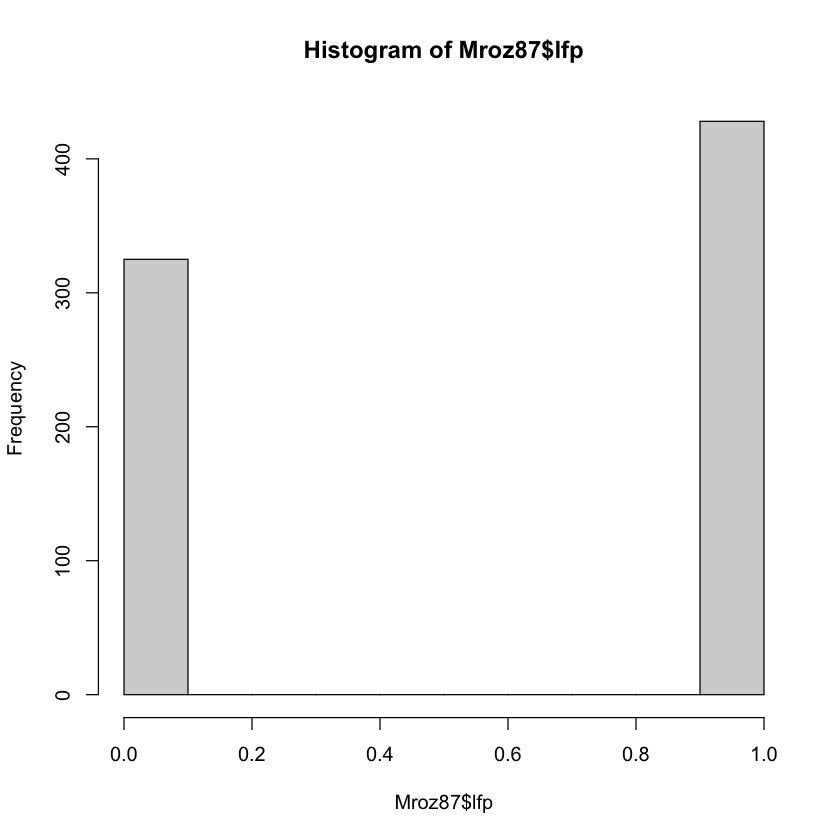

In [4]:
hist(Mroz87$lfp)

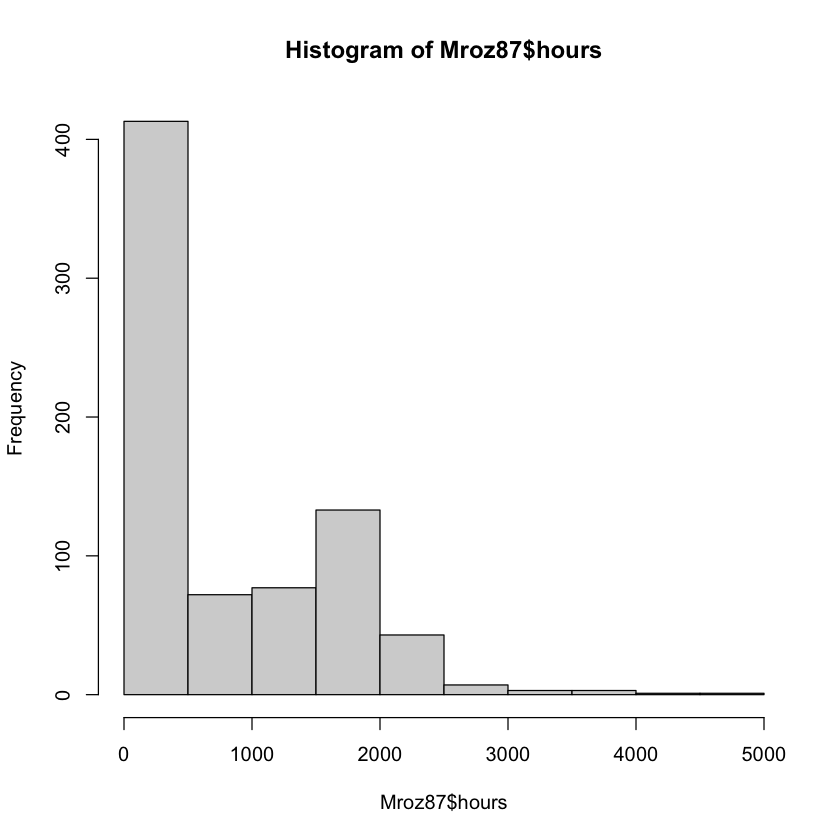

In [5]:
hist(Mroz87$hours)

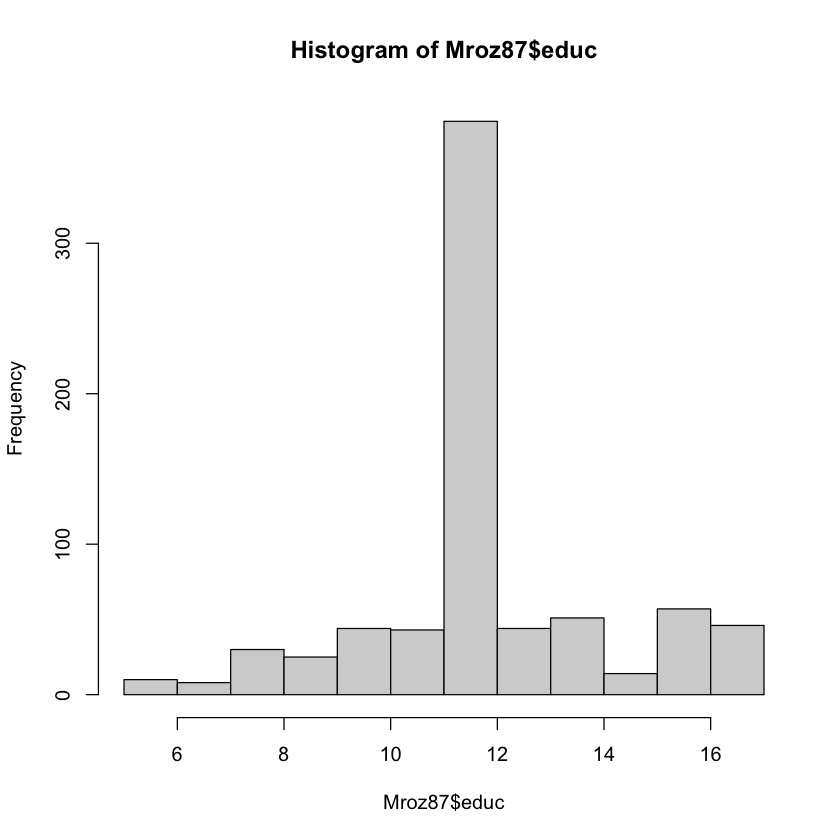

In [6]:
hist(Mroz87$educ)

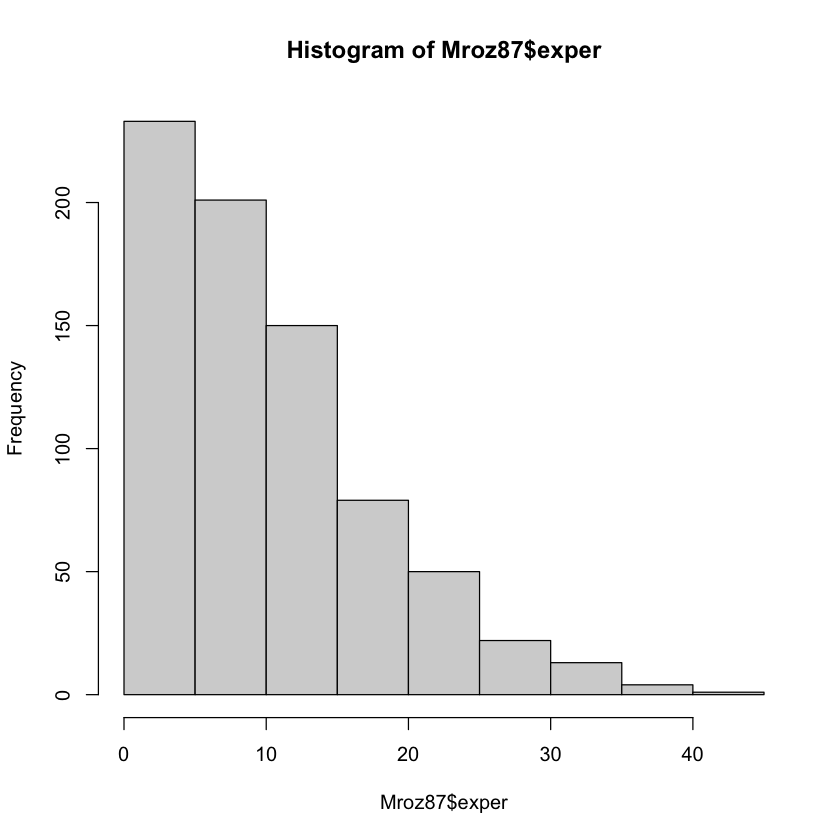

In [7]:
hist(Mroz87$exper)

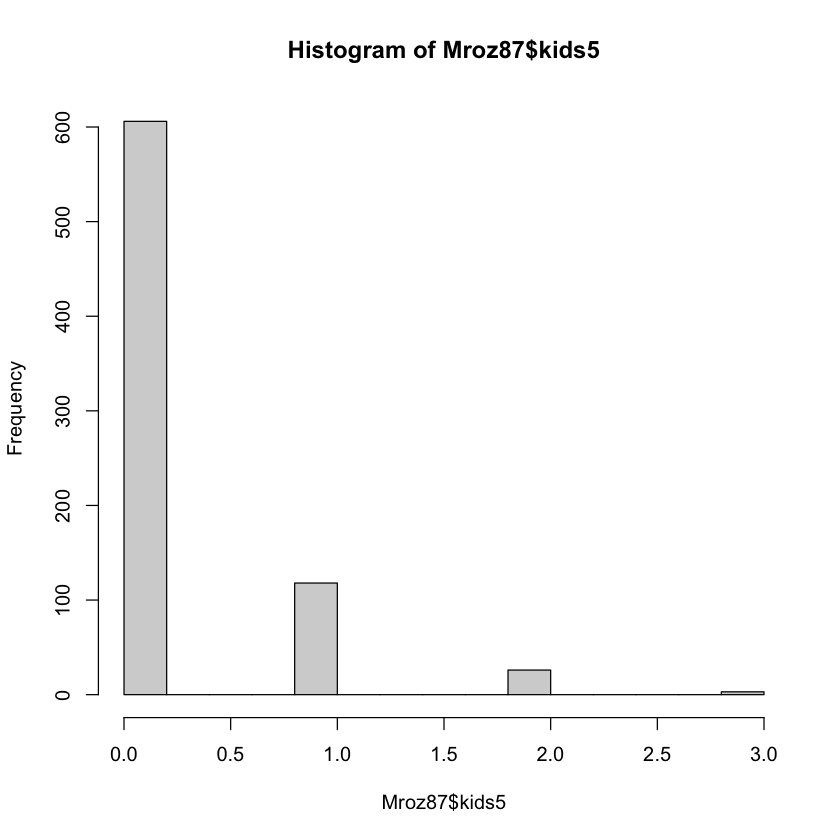

In [8]:
hist(Mroz87$kids5)

In [9]:
summary(lm(hours ~  age + educ + exper + kids5, data =Mroz87))


Call:
lm(formula = hours ~ age + educ + exper + kids5, data = Mroz87)

Residuals:
    Min      1Q  Median      3Q     Max 
-1916.6  -530.2  -153.6   522.5  3568.8 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1335.306    235.649   5.667 2.08e-08 ***
age          -31.308      3.961  -7.904 9.67e-15 ***
educ          27.086     12.240   2.213   0.0272 *  
exper         48.040      3.642  13.191  < 2e-16 ***
kids5       -447.855     58.413  -7.667 5.48e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 753 on 748 degrees of freedom
Multiple R-squared:  0.2571,	Adjusted R-squared:  0.2531 
F-statistic: 64.71 on 4 and 748 DF,  p-value: < 2.2e-16


In [10]:
summary(tobit(formula = hours ~ age+ educ + exper  + kids5, data =Mroz87))


Call:
tobit(formula = hours ~ age + educ + exper + kids5, data = Mroz87)

Observations:
         Total  Left-censored     Uncensored Right-censored 
           753            325            428              0 

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) 1349.8763   386.2991   3.494 0.000475 ***
age          -60.7678     6.8882  -8.822  < 2e-16 ***
educ          73.2910    20.4746   3.580 0.000344 ***
exper         80.5353     6.2878  12.808  < 2e-16 ***
kids5       -918.9181   111.6607  -8.230  < 2e-16 ***
Log(scale)     7.0332     0.0371 189.565  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Scale: 1134 

Gaussian distribution
Number of Newton-Raphson Iterations: 4 
Log-likelihood: -3827 on 6 Df
Wald-statistic: 243.3 on 4 Df, p-value: < 2.22e-16 


We have to add the `x=TRUE` command so the model saves the **x** values

In [11]:
tobit.mdl <-tobit(formula = hours ~ age+ educ + exper  + kids5,x=TRUE, data =Mroz87)
tobit.coef<-(tobit.mdl$coef)
tobit.scale<-(tobit.mdl$scale)

The vector of marginal effects (at mean values and for **y > 0**) should be as follows. The `[-1]` used to remove the intercept term from the final vector, but not from within the adjustment term. 

In [12]:
tibble(pnorm(sum(apply(tobit.mdl$x,2,FUN=mean) * tobit.coef)/tobit.scale) * 
  tobit.coef[-1])

... * tobit.coef[-1]
<dbl>
-36.79049
44.37238
48.75827
-556.33825


See lecture notes for details

In [13]:
denom<-pnorm(sum(apply(tobit.mdl$x,2,FUN=mean) * tobit.coef)/tobit.scale) 
num<-dnorm(sum(apply(tobit.mdl$x,2,FUN=mean) * tobit.coef)/tobit.scale)
tibble(tobit.coef*(1-(num/denom)*((sum(apply(tobit.mdl$x,2,FUN=mean) * tobit.coef)/tobit.scale)+num/denom)))

tobit.coef * ...
<dbl>
574.69066
-25.87103
31.20260
34.28675
-391.21633


### Heckman 2-steps estimation 
Heckman's idea was to treat the selection problem as if it were an obmitted variable problem. 

* A first-stage is the probit equation to estimate the selection process (who is in the labor force), and the result from that equation are used to construct a variable that captures the selection effect in the wage equation.

* labor force selection equation with selection. 

The selection equation should include regressors variables that are likely to affect the selection process, in this case, is the variable that effect whether or not a married woman would be in the labor force. Heckman and Mroz have found evidence that Labor market experience is endogenous variable, it is also guided that "Kids5" - the number of kids under 5 years old that married women have, is that variable. 

In [14]:
ols.wage <- lm(log(wage) ~ educ + exper + I( exper^2 ) + city, data=subset(Mroz87, lfp==1))
summary(ols.wage)


Call:
lm(formula = log(wage) ~ educ + exper + I(exper^2) + city, data = subset(Mroz87, 
    lfp == 1))

Residuals:
     Min       1Q   Median       3Q      Max 
-3.10084 -0.32453  0.05292  0.36261  2.34806 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.5308476  0.1990253  -2.667  0.00794 ** 
educ         0.1057097  0.0143280   7.378 8.58e-13 ***
exper        0.0410584  0.0131963   3.111  0.00199 ** 
I(exper^2)  -0.0007973  0.0003938  -2.025  0.04352 *  
city         0.0542225  0.0680903   0.796  0.42629    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6667 on 423 degrees of freedom
Multiple R-squared:  0.1581,	Adjusted R-squared:  0.1501 
F-statistic: 19.86 on 4 and 423 DF,  p-value: 5.389e-15


In [15]:
heck2step <- heckit( lfp ~ age + I( age^2 ) + kids5 + huswage + educ,
                 log(wage) ~ educ + exper + I( exper^2 ) + city, data=Mroz87 )
summary(heck2step)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-0.6204198881,1.5164451995,-0.40912780,6.825643e-01
age,0.0100365481,0.0689931183,0.14547173,8.843781e-01
I(age^2),-0.0004891427,0.0007841401,-0.62379500,5.329545e-01
kids5,-0.8546564102,0.1153681957,-7.40807642,3.501843e-13
huswage,-0.0421711035,0.0124157804,-3.39657293,7.188057e-04
educ,0.1476737404,0.0234280139,6.30329746,5.004215e-10
(Intercept),-0.5471531194,0.2890637948,-1.89284556,5.876839e-02
educ,0.1064520958,0.0171744578,6.19827986,9.478180e-10
exper,0.0411568989,0.0131804681,3.12256732,1.862631e-03
I(exper^2),-0.0008013972,0.0003949725,-2.02899490,4.281632e-02
